In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from os import listdir
from collections import Counter


In [ ]:
def load_doc(filename):
    with open(filename) as file:
        text = file.readlines()
        return text

filename = "/content/drive/MyDrive/Flickr8k.token.txt"
text = load_doc(filename)
for line in text[:10]:
    print(line,end='')

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [ ]:
def image_to_captions(text):
    hash_map = {}
    for line in text:
        token = line.split()
        image_id = token[0].split('.')[0] # separating with '.' to extract image id (removing .jpg)
        image_caption = ' '.join(token[1: ])

        if(image_id not in hash_map):
            hash_map[image_id] = [image_caption]
        else:
            hash_map[image_id].append(image_caption)

    return hash_map


map_img_to_captions = image_to_captions(text)
print(*map_img_to_captions['1000268201_693b08cb0e'],sep='\n')

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [ ]:
def preprocess(map_img_to_captions):
    preprocessed_captions = []
    for key in map_img_to_captions.keys():
        for idx in range(len(map_img_to_captions[key])):
            tokens = map_img_to_captions[key][idx].split()
            tokens = [token.lower() for token in tokens if len(token)>1 if token.isalpha()]
            map_img_to_captions[key][idx] = ' '.join(tokens)

    return map_img_to_captions


preprocessed_map = preprocess(map_img_to_captions)
preprocessed_map['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
def create_vocabulary(preprocessed_map):
    vocabulary = set()
    for img_captions in preprocessed_map.values(): # list of 5 captions for each image
        for caption in img_captions:
            for token in caption.split():
                vocabulary.add(token)
    return vocabulary


vocabulary = create_vocabulary(preprocessed_map)
print('Vocabulary size',len(vocabulary))

Vocabulary size 8357


In [ ]:
def img_id_train(filename):
    with open(filename) as file:
        data = file.readlines()
        train_img_name = []
        for img_id in data:
            train_img_name.append(img_id.split('.')[0])
    return train_img_name

train_img_name = img_id_train('/content/drive/MyDrive/Flickr_8k.trainImages.txt')
test_img_name  = img_id_train('/content/drive/MyDrive/Flickr_8k.testImages.txt')
print(*train_img_name[:5],sep='\n')
print('\nNumber of images in train data',len(train_img_name))
print('\nNumber of images in train data',len(test_img_name))

2513260012_03d33305cf
2903617548_d3e38d7f88
3338291921_fe7ae0c8f8
488416045_1c6d903fe0
2644326817_8f45080b87

Number of images in train data 6000

Number of images in train data 1000


In [ ]:
def load_captions_train(filename):
    doc = load_doc(filename)
    train_captions = {}

    for line in doc:
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]

        if(image_id in train_img_name):
            if(image_id not in train_captions):
                train_captions[image_id] = []

            modified_caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            train_captions[image_id].append(modified_caption)

    return train_captions


train_captions = load_captions_train('/content/drive/MyDrive/preprocessed_captions.txt')
print(*train_captions['1000268201_693b08cb0e'],sep='\n')

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [ ]:
def preprocess_image(img_path):
    img = image.load_img(img_path,target_size=(299,299))
    # type(img): PIL.Image.Image
#     plt.figure(figsize=(12,6))
#     plt.subplot(121)
#     plt.imshow(img)
#     plt.title('Original Image(Resized)')

    img = image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
    img = np.expand_dims(img, axis=0) #Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
    img = preprocess_input(img) # preprocess image as per Inception-V3 model
#     plt.subplot(122)
#     plt.imshow(img[0])
#     plt.title('Preprocessed image for Inception-V3')

    return img  # shape: (1, 299, 299, 3)

In [ ]:
# Load Inception-V3 model
model = InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_new = Model(inputs=model.input, outputs=model.layers[-2].output) # outputs=(second last layer output)

# model.layers            list of layers
# model.input             <tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>
# model.layers[-1].output <tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32> 1000 target classes
# model.layers[-2].output <tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

96116736/96112376 [==============================] - 0s 0us/step


In [ ]:
train_features = load(open("/content/drive/MyDrive/encoded_train_images.pkl", "rb"))

# Create a list of all the training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)

print(len(all_train_captions))
print(*all_train_captions[:10],sep='\n')

30000
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq black dog and spotted dog are fighting endseq
startseq black dog and dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


In [ ]:
corpus = []
for caption in all_train_captions:
    for token in caption.split():
        corpus.append(token)

hash_map = Counter(corpus)
vocab = []
for token,count in hash_map.items():
    if(count>=10):
        vocab.append(token)

print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

Number of original tokens 7265
Number of tokens after threshold 1643


In [ ]:
word_to_index = {}
index_to_word = {}

for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))

1643


In [ ]:
def max_len_caption(all_train_captions):
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

max_length_caption = max_len_caption(all_train_captions)

Maximum length of caption=  33


In [ ]:
temp='Flicker8k_Dataset/'
X1, X2, y = list(), list(), list()
for key, des_list in train_captions.items():
	pic = train_features[temp+key +'.jpg']
	for cap in des_list:
		seq = [word_to_index[word] for word in cap.split(' ') if word in word_to_index]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen = max_length_caption)[0]
			out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
			# store
			X1.append(pic)
			X2.append(in_seq)
			y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)

In [ ]:
embeddings_index = {} # empty dictionary
f = open('/content/drive/MyDrive/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1644, 200)

In [ ]:

embedding_dim = 200
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length_caption,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      328800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
 model.fit([X1, X2], y, epochs = 100, batch_size = 512)

Epoch 1/100
571/571 [==============================] - 54s 87ms/step - loss: 4.7867 - accuracy: 0.1846
Epoch 2/100
571/571 [==============================] - 52s 91ms/step - loss: 3.4927 - accuracy: 0.2873
Epoch 3/100
571/571 [==============================] - 50s 88ms/step - loss: 3.1988 - accuracy: 0.3167
Epoch 4/100
571/571 [==============================] - 51s 90ms/step - loss: 3.0396 - accuracy: 0.3314
Epoch 5/100
571/571 [==============================] - 51s 89ms/step - loss: 2.9301 - accuracy: 0.3427
Epoch 6/100
571/571 [==============================] - 49s 86ms/step - loss: 2.8413 - accuracy: 0.3538
Epoch 7/100
571/571 [==============================] - 49s 86ms/step - loss: 2.7713 - accuracy: 0.3612
Epoch 8/100
571/571 [==============================] - 49s 86ms/step - loss: 2.7153 - accuracy: 0.3675
Epoch 9/100
571/571 [==============================] - 49s 87ms/step - loss: 2.6569 - accuracy: 0.3732
Epoch 10/100
571/571 [==============================] - 50s 88ms/step - l

In [ ]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length_caption):
        seq = [word_to_index[word] for word in start.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen = max_length_caption)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
test_features = load(open("/content/drive/MyDrive/encoded_test_images.pkl", "rb"))

In [ ]:
pred = greedy_search(test_features['Flicker8k_Dataset/2594042571_2e4666507e.jpg'].reshape(1,2048))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
sentence_bleu(preprocessed_map['2594042571_2e4666507e'],pred )

0.5639181311076842

In [ ]:
pred_good, pred_bad, bleus = [], [], []
for img in test_features.keys():
  pred = greedy_search(test_features[img].reshape(1,2048))
  bleu = sentence_bleu(preprocessed_map[img.split('/')[1].split('.')[0]],pred )
  bleus.append(bleu)
  if bleu > 0.8 and len(pred_good) < 5:
      pred_good.append([img,bleu])
  elif bleu < 0.3 and len(pred_bad) < 5:
      pred_bad.append([img,bleu])
  if len(pred_good)==50 and len(pred_bad)==50 :
    break

In [ ]:
import zipfile
!unzip glove.6B.200d.txt.zip

Archive:  glove.6B.200d.txt.zip
  inflating: glove.6B.200d.txt       


In [ ]:
pred_bad

[['Flicker8k_Dataset/3110649716_c17e14670e.jpg', 0.12845265832248395],
 ['Flicker8k_Dataset/2309860995_c2e2a0feeb.jpg', 0.2289057615836192],
 ['Flicker8k_Dataset/2358898017_24496b80e8.jpg', 0.13507116616915937],
 ['Flicker8k_Dataset/1248940539_46d33ed487.jpg', 0.29093602546912434],
 ['Flicker8k_Dataset/3119875880_22f9129a1c.jpg', 0.2528099584126906]]

In [ ]:
pred_good

[['Flicker8k_Dataset/3385593926_d3e9c21170.jpg', 0.9192356457808182],
 ['Flicker8k_Dataset/1258913059_07c613f7ff.jpg', 0.8065008590125561],
 ['Flicker8k_Dataset/241347760_d44c8d3a01.jpg', 0.8068176930390999],
 ['Flicker8k_Dataset/2435685480_a79d42e564.jpg', 0.8932508234132014],
 ['Flicker8k_Dataset/3502343542_f9b46688e5.jpg', 0.8315345797067449]]

two children bounce on bed


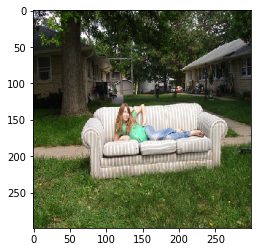

In [ ]:
pred = greedy_search(test_features['Flicker8k_Dataset/514990193_2d2422af2c.jpg'].reshape(1,2048))
img = image.load_img('514990193_2d2422af2c.jpg',target_size=(299,299))
plt.imshow(img)
print(pred)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')